In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential



DATA_PATH = "DATA_PATH"
df = pd.read_csv("data.csv")
df

,File_Path,Category,Target
0,MoroccanMusic\andalusian\andalusian.00000.wav,andalusian,0
1,MoroccanMusic\andalusian\andalusian.00001.wav,andalusian,0
2,MoroccanMusic\andalusian\andalusian.00002.wav,andalusian,0
3,MoroccanMusic\andalusian\andalusian.00003.wav,andalusian,0
4,MoroccanMusic\andalusian\andalusian.00004.wav,andalusian,0
...,...,...,...
595,MoroccanMusic\rap\rap.00095.wav,rap,5
596,MoroccanMusic\rap\rap.00096.wav,rap,5
597,MoroccanMusic\rap\rap.00097.wav,rap,5
598,MoroccanMusic\rap\rap.00098.wav,rap,5


In [1]:
sample_df = df.drop_duplicates(subset=['Target'])
sample_df


NameError: name 'df' is not defined

In [3]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(row[1][0])
    signals[row[1][1]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][1]] = mel_spec
    
    # mfcc = librosa.feature.mfcc(y=signal , sr=rate , n_mfcc=13, dct_type=3)
    # mfccs[row[1][1]] = mfcc


0it [00:00, ?it/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13796\344593235.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal , rate = librosa.load(row[1][0])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13796\344593235.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signals[row[1][1]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13796\344593235.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [4]:
print(signals.keys())

dict_keys(['andalusian', 'chaabi', 'gnawa', 'imazighn', 'rai', 'rap'])


In [5]:
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(6):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            


IndexError: list index out of range

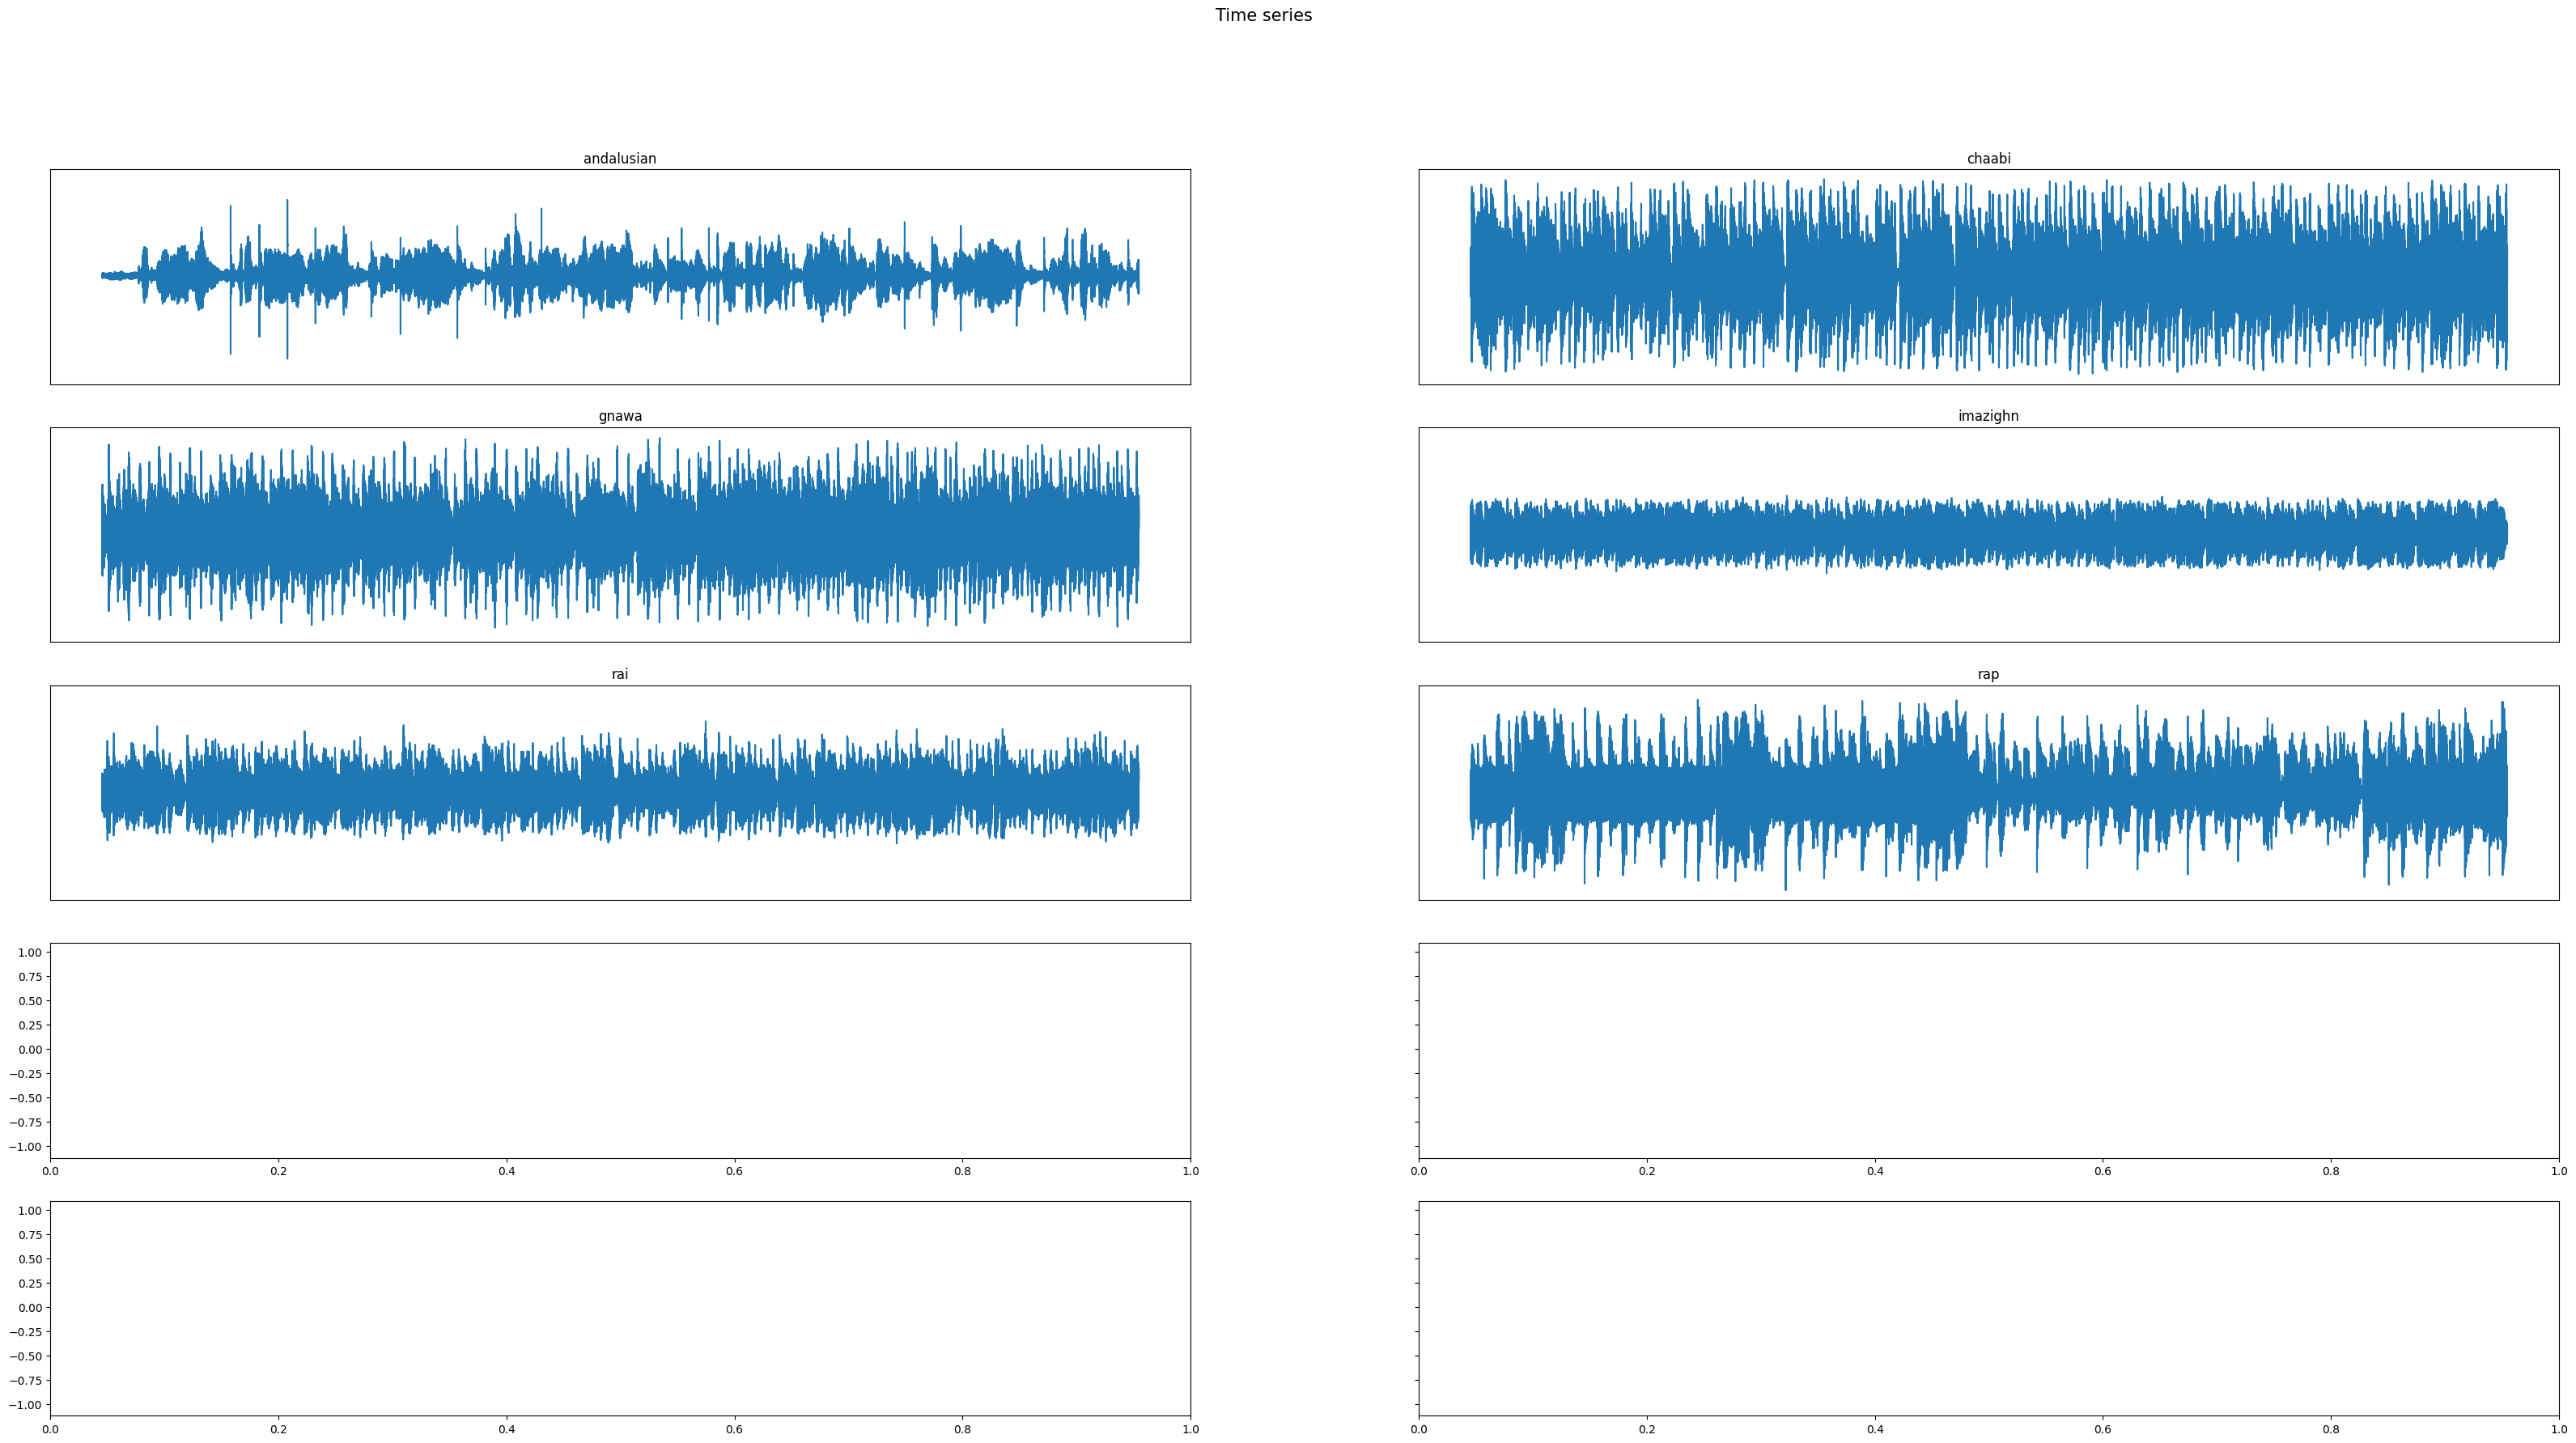

In [6]:
plot_signal(signals)


In [8]:
def extract_features(file_path,duration=15):
    audio , rate = librosa.load(file_path, duration=duration)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=rate,  n_fft=2048, hop_length=512)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Generate MFCCs
    # mfcc = librosa.feature.mfcc(S=sig,sr=sr ,n_mfcc=N_MFCC)
    
    return mel_spectrogram_db


In [ ]:
X = []
Y = []
for data in tqdm(df.iterrows()):
    mel_spectrogram_db = extract_features(data[1][0])
    
    X.append(mel_spectrogram_db)  
                
    # Assuming directory names are class labels
    Y.append(data[1][2])



Augmentation


In [3]:
import librosa
import numpy as np
import os

# Augmentation functions
def time_stretch(y, rate=1.0):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr=22050, n_steps=0):
    return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    return augmented_data.astype(type(y[0]))

# Function to load and preprocess audio files
def preprocess_audio(file_path, duration=15):
    y, sr = librosa.load(file_path, duration=duration)
    # Apply augmentations
    y_stretched = time_stretch(y, rate=1.2)
    # y_shifted = pitch_shift(y, sr, n_steps=2)  # Uncommented
    y_noisy = add_noise(y)
    return sr, [y_stretched, y_noisy]

# Feature extraction and augmentation
X, Y = [], []  # Initialize lists for features and labels

for index, row in df.iterrows():
        file_path = row['File_Path']
        label = row['Target']
        
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        # Preprocess and augment audio
        sr, augmented_audios = preprocess_audio(file_path, duration=15)
        
        for audio in augmented_audios:
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
            if mel_spectrogram.shape[1] > 0:  # Ensure mel_spectrogram has frames
                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
                X.append(mel_spectrogram_db)
                Y.append(label)


File not found: MoroccanMusic\chaabi\chaabi.00037.wav
File not found: MoroccanMusic\chaabi\chaabi.00039.wav
File not found: MoroccanMusic\chaabi\chaabi.00040.wav
File not found: MoroccanMusic\chaabi\chaabi.00041.wav
File not found: MoroccanMusic\chaabi\chaabi.00043.wav
File not found: MoroccanMusic\chaabi\chaabi.00044.wav
File not found: MoroccanMusic\chaabi\chaabi.00045.wav
File not found: MoroccanMusic\chaabi\chaabi.00046.wav
File not found: MoroccanMusic\chaabi\chaabi.00047.wav
File not found: MoroccanMusic\chaabi\chaabi.00049.wav
File not found: MoroccanMusic\chaabi\chaabi.00084.wav
File not found: MoroccanMusic\chaabi\chaabi.00087.wav
File not found: MoroccanMusic\chaabi\chaabi.00088.wav
File not found: MoroccanMusic\chaabi\chaabi.00098.wav


In [19]:
for index, row in df.iterrows():
    if index ==1:
        file_path = row[0]
        label = row[2]
        print(file_path)
        print(label)

MoroccanMusic\andalusian\andalusian.00001.wav
0


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20376\4129918675.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_path = row[0]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20376\4129918675.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[2]


### Fixing : X

In [4]:
# Find the maximum number of frames across all features
max_frames = max([feature.shape[1] for feature in X])

# Pad shorter features to match the maximum number of frames
padded_features_list = []
for feature in X:
    if feature.shape[1] < max_frames:
        # Pad the feature to match the maximum frame length
        padding = np.zeros((feature.shape[0], max_frames - feature.shape[1]))
        feature_padded = np.concatenate([feature, padding], axis=1)
        padded_features_list.append(feature_padded)
    else:
        padded_features_list.append(feature)
        
        
# Fixing X to the appropriate format
X = np.array(padded_features_list)
X = np.expand_dims(X, axis=-1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1172, 128) + inhomogeneous part.

In [30]:
print(X.shape)

(1172, 128, 646, 1)


### One Hot Encoding : Y 

In [12]:

num_classes = len(np.unique(Y))  # Number of unique classes
Y = np.array(Y)  # Ensure labels are in array format
Y = to_categorical(Y, num_classes=num_classes)


### Spliting the Data

In [13]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


### Model Definition

In [15]:
f1=3
f2=3
input_shape = (128,646,1)
model = Sequential([
                                layers.Conv2D(16, (f1,f2), padding= 'same', activation='relu', input_shape=input_shape ),
                                layers.MaxPooling2D(2, padding='same'),
                                
                                layers.Conv2D(32, (f1,f2), padding= 'same', activation='relu'),
                                layers.MaxPooling2D(2, padding='same'),
                                layers.Dropout(0.3),

                                layers.Conv2D(64, (f1,f2), padding= 'same', activation='relu'),
                                layers.MaxPooling2D(2, padding='same'),
                                layers.Dropout(0.3),
            
                                layers.Conv2D(128, (f1,f2),padding='same', activation = 'relu'),
                                layers.MaxPooling2D(2 ,padding='same'),
                                layers.Dropout(0.3),
            
                                layers.GlobalAveragePooling2D(),
            
                                layers.Dense(num_classes, activation='softmax')
   
                                ])
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
model.summary()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 646, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 323, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 323, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 162, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 162, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 162, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 81, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 81, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 81, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 41, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 41, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,926 (382.52 KB)

 Trainable params: 97,926 (382.52 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [16]:
# Train the model
history = model.fit(
    X_train, Y_train, 
    shuffle = True,   
    epochs=60,         
    batch_size=32,     
    validation_split=0.2  
)


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.1762 - loss: 7.0868 - val_accuracy: 0.1458 - val_loss: 2.1729
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 517ms/step - accuracy: 0.2096 - loss: 2.2923 - val_accuracy: 0.2188 - val_loss: 1.7864
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step - accuracy: 0.2127 - loss: 1.8134 - val_accuracy: 0.2292 - val_loss: 1.7930
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.1810 - loss: 1.7945 - val_accuracy: 0.1458 - val_loss: 1.7926
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - accuracy: 0.1765 - loss: 1.7906 - val_accuracy: 0.2188 - val_loss: 1.7896
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.1889 - loss: 1.7841 - val_accuracy: 0.2188 - val_loss: 1.7891
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - accuracy: 0.2088 - loss: 1.7870 - val_accuracy: 0.1771 - val_loss: 1.7880
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.2194 - loss: 1.7717 - val_accuracy: 0.

### Model Evaluation

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=32)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9025 - loss: 0.3583
Test Loss: 0.3987
Test Accuracy: 0.8917


### Predictions (X_test)

In [18]:
predictions = model.predict(X_test)

# Convert predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)

# Print the first 5 predictions and true labels
print(f"Predicted classes: {predicted_classes[:5]}")
print(f"True classes: {true_classes[:5]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Predicted classes: [1 4 5 0 1]
True classes: [1 4 5 0 1]


In [19]:
classes = sample_df.Category
class_dict = {i:x for i,x in enumerate(classes)}

predicted_indices = np.argmax(model.predict(X_test), axis=1)
true_indices = np.argmax(Y_test, axis=1)

# Map indices to class names
predicted_class_names = [class_dict[i] for i in predicted_indices]
true_class_names = [class_dict[i] for i in true_indices]

# Print first 5 predictions
print("Predicted class names:", predicted_class_names[:5])
print("Predicted class names:", true_class_names[:5])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Predicted class names: ['chaabi', 'rai', 'rap', 'andalusian', 'chaabi']
Predicted class names: ['chaabi', 'rai', 'rap', 'andalusian', 'chaabi']


In [20]:
print(class_dict)

{0: 'andalusian', 1: 'chaabi', 2: 'gnawa', 3: 'imazighn', 4: 'rai', 5: 'rap'}


### MAKE NEW PREDICITION

In [13]:

def preprocess_audio(file_path, duration=15):
    # Load the audio file
    audio, rate = librosa.load(file_path, duration=duration)
    
    # Extract Mel spectrogram features
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=rate, n_fft=2048, hop_length=512)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Ensure the shape matches the input shape of the model
    mel_spectrogram_db = mel_spectrogram_db[:, :646]  # Ensure 646 frames (adjust if necessary)
    mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)  # Add channel dimension
    
    return np.expand_dims(mel_spectrogram_db, axis=0)  # Add batch dimension


In [25]:
model = tf.keras.models.load_model("model.h5")
class_dict = {0: 'andalusian', 1: 'chaabi', 2: 'gnawa', 3: 'imazighn', 4: 'rai', 5: 'rap'}

file_path = r"C:\Users\LENOVO\Desktop\Moroccan Music Classifier\myTest\0101.WAV"
preprocessed_audio = preprocess_audio(file_path)

# Make prediction
predictions = model.predict(preprocessed_audio)
# predicted_class_index = np.argmax(predicted_probs, axis=1)[0]
# predicted_class_name = class_dict[predicted_class_index]
predicted_class = class_dict[np.argmax(predictions)]

print(predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
rap


In [23]:
model.save('model.h5')


In [23]:
import librosa
import numpy as np
import soundfile as sf

def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def time_stretch(y, rate=1.0):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, n_steps=0):
    return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = augmented_data.astype(type(y[0]))
    return augmented_data

# Example usage
file_path = r'C:\Users\LENOVO\Desktop\Moroccan Music Classifier\myTest\draga.WAV'
y, sr = load_audio(file_path)

# Time stretching
y_stretched = time_stretch(y, rate=1.2)

# Pitch shifting
# y_shifted = pitch_shift(y, sr, n_steps=2)

# Adding noise
y_noisy = add_noise(y, noise_factor=0.007)

# Save augmented data
sf.write('stretched.wav', y_stretched, sr)
# sf.write('shifted.wav', y_shifted, sr)
sf.write('noisy.wav', y_noisy, sr)

In [26]:
import pandas as pd
import librosa

# Load the CSV file into a DataFrame
df = pd.read_csv("data.csv")

# Function to check if an audio file is empty
def is_audio_empty(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=None)
        return len(audio) == 0
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return True

# Check each file in the DataFrame
empty_audio_files = df[df['File_Path'].apply(is_audio_empty)]

# Print the paths of empty audio files
if not empty_audio_files.empty:
    print("Empty audio files found:")
    print(empty_audio_files['File_Path'].tolist())
else:
    print("No empty audio files found.")

Empty audio files found:
['MoroccanMusic\\chaabi\\chaabi.00037.wav', 'MoroccanMusic\\chaabi\\chaabi.00039.wav', 'MoroccanMusic\\chaabi\\chaabi.00040.wav', 'MoroccanMusic\\chaabi\\chaabi.00041.wav', 'MoroccanMusic\\chaabi\\chaabi.00043.wav', 'MoroccanMusic\\chaabi\\chaabi.00044.wav', 'MoroccanMusic\\chaabi\\chaabi.00045.wav', 'MoroccanMusic\\chaabi\\chaabi.00046.wav', 'MoroccanMusic\\chaabi\\chaabi.00047.wav', 'MoroccanMusic\\chaabi\\chaabi.00049.wav', 'MoroccanMusic\\chaabi\\chaabi.00084.wav', 'MoroccanMusic\\chaabi\\chaabi.00087.wav', 'MoroccanMusic\\chaabi\\chaabi.00088.wav', 'MoroccanMusic\\chaabi\\chaabi.00098.wav']
